# 作成したプログラムのテスト用jupyter notebookです 

## `repository/requirements.txt`にあるライブラリをインストール

In [2]:
%%capture
!pip install -r ../repository/requirements.txt

## パッケージインポート

In [3]:
import os
import math
import numpy as np
from tensorflow.keras import models
import pickle
import json

# from runnertools import runner_io
import runner_io

args_file:/usr/local/qai/args/args.json


## ファイルパス読み込み

- モデル

In [4]:
model_path = runner_io.inventory('model_inventory_bbb')[0]
model = models.load_model(model_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


- データ

In [5]:
data_path = runner_io.inventory('data_inventory_aaa')[0]
f = open(data_path, 'rb')
(x_train, y_train), (x_test, y_test) = pickle.load(f)
f.close()

## 引数の読み込み
* 引数の読み込み部分は要検討の事柄が多いので、暫定的なコードになります

In [6]:
runner_io.arg('a')

123

## 推論

In [7]:
result_list = model.predict(x_test)

## データ計測

### 数式表示用パッケージ

In [8]:
from IPython.display import display, Math

### 度数分布計測

In [9]:
sections = 25
y_max = max(max(result_list), max(y_test))
sec_width = y_max/sections
sec_typicals = []
for i in range(sections):
    typical = (i+0.5)*sec_width
    sec_typicals.append(typical)
sec_typicals = np.array(sec_typicals)
actual_freq = np.zeros(sections)
result_freq = np.zeros(sections)
def sec_index(y):
    if y==y_max:
        return (sections-1)
    index = int(y/sec_width)
    return index
for y in y_test:
    index = sec_index(y)
    actual_freq[index] += 1
for result in result_list:
    index = sec_index(result)
    result_freq[index] += 1
actual_freq /= len(y_test)
result_freq /= len(result_list)

### MSE(Mean Squared Error, 平均二乗誤差), MAE(Mean Absolute Error, 平均絶対誤差)

In [10]:
mse, mae = model.evaluate(x_test, y_test, verbose=0)
display(Math('\\text{MSE} = ' + str(mse)))
display(Math('\\text{MAE} = ' + str(mae)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### カルバック・ライブラー情報量

In [11]:
kl_div = 0.0
for i in range(sections):
    f_i = float(result_freq[i])
    g_i = float(actual_freq[i])
    if not(f_i<=0) and not(g_i<=0):
        kl_div += f_i*math.log(f_i/g_i)

display(Math('D_\\text{KL} = ' + str(kl_div)))

<IPython.core.display.Math object>

## 結果保存

### 計測値保存

In [12]:
os.makedirs('artifact', exist_ok=True)

result_text_path = 'artifact/result.txt'
with open(result_text_path, 'w') as f:
    f.write('  MSE=' + str(mse))
    f.write('  MAE=' + str(mae))
    f.write('  KL divergence(f,g)=' + str(kl_div))
runner_io.output(result_text_path)

result_json_path = 'artifact/result.json'
with open(result_json_path, 'w') as f:
    result_json = {
                    "MSE":    float(mse),
                    "MAE":    float(mae),
                    "KL_div": float(kl_div)
                }
    json.dump(result_json, f)
runner_io.output(result_json_path)

### グラフとして保存

In [13]:
import matplotlib.pyplot as plt
marker='o'
markersize=5
fillstyle="none"

### 実際と予測値の価格分布の比較

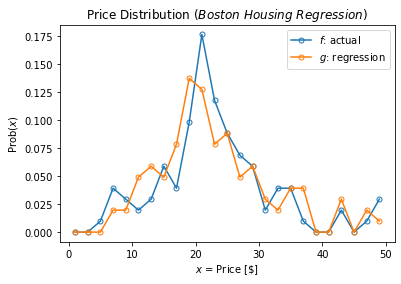

In [14]:
graph_label = {
                'actual':     r'$f$: actual', 
                'regression': r'$g$: regression'
              }
title=r'Price Distribution (${\it Boston \ Housing \ Regression}$)'
xlabel=r'$x$ = Price [\$]'
ylabel=r'Prob($x$)'
plt.plot(sec_typicals, actual_freq, marker=marker, markersize=markersize ,fillstyle=fillstyle, label=graph_label['actual'])
plt.plot(sec_typicals, result_freq, marker=marker, markersize=markersize ,fillstyle=fillstyle, label=graph_label['regression'])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()

plt.savefig('artifact/regression_result_distribution.png')
plt.savefig('artifact/regression_result_distribution.svg')
plt.savefig('artifact/regression_result_distribution.pdf')

runner_io.output('artifact/regression_result_distribution.png')
runner_io.output('artifact/regression_result_distribution.svg')
runner_io.output('artifact/regression_result_distribution.pdf')

### 実際と予測値の価格をそれぞれ軸に取ったときの散布図

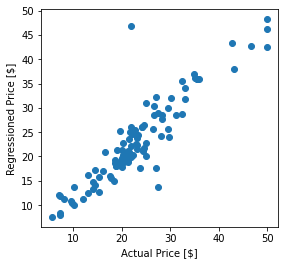

In [15]:
plt.figure()
xlabel=r'Actual Price [\$]'
ylabel=r'Regressioned Price [\$]'
marker='o'
markersize=8
fillstyle="none"
g = plt.subplot()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
g.set_aspect('equal')
g.scatter(y_test, result_list.T[0], marker=marker)

plt.savefig('artifact/scatter.png')
plt.savefig('artifact/scatter.svg')
plt.savefig('artifact/scatter.pdf')

runner_io.output('artifact/scatter.png')
runner_io.output('artifact/scatter.svg')
runner_io.output('artifact/scatter.pdf')